In [87]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import os
import pickle
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Conv1D, UpSampling1D, Cropping1D, \
    LSTM, Bidirectional, TimeDistributed, LeakyReLU, Dropout, Flatten, Reshape

In [2]:
df_merged=pd.read_csv('dfmerged.csv')
cols=['id', 'TimeMS', 'Avg_Velocity', 'PWM_Output','SG_NoFilter', 'Setpoint', 'StrainGage', 'avg_current','current_filter', 'ticks', 'True_Endstop_Time_ms', 'Articulation','Tissue', 'Tissue_Thickness_inch', 'Reload', 'Firing_Type']
df_merged=df_merged[cols]

In [3]:
uniqueids=np.unique(df_merged['id'])

/var/folders/_b/hfgvzy6556bfwk4xnjfgfy0m0000gn/T/ipykernel_25734/1163778781.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TimeDateTime'] = pd.to_datetime(df['TimeMS'], unit='ms')


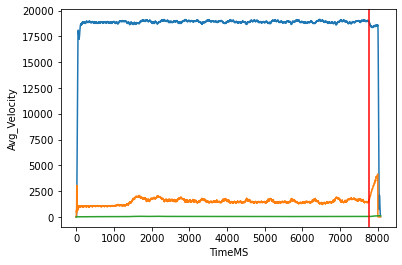

<Figure size 2016x720 with 0 Axes>

In [55]:
df=df_merged[df_merged.id==np.random.choice(uniqueids)]
sns.lineplot(data=df,x="TimeMS",y="Avg_Velocity")
sns.lineplot(data=df,x="TimeMS",y="avg_current")
sns.lineplot(data=df,x="TimeMS",y="StrainGage")
plt.axvline(df['True_Endstop_Time_ms'].values[0],color="red")
plt.figure(figsize = (28,10))
df['TimeDateTime'] = pd.to_datetime(df['TimeMS'], unit='ms')
df = df.set_index(pd.DatetimeIndex(df['TimeDateTime']))

In [91]:
def rolling_windows(x, t, window_size, step_size=1):
    """Split time series data into rolling windows.
    
    The time series data (x) are expected to be an nD array, with n >= 1 and
    of the shape (# time stamps, ...); and the time stamps (t) in the form of
    a 1D-array are expected to be provided separately.
    
    The outputs are the windowed data (x_win) in the form of an (n+1)D array
    of the shape (# windows, window size, ...); and start times of the windows
    (t_win).
    """
    assert len(x) == len(t)
    n_windows = (len(x) - window_size) // step_size + 1
    #print('Shape of x from rolling window is {},n_windows is {},window size is {}'.format(x.shape[1:],n_windows,window_size))
    x_win = np.full((n_windows, window_size, *(x.shape[1:])), np.nan)
    for i in range(window_size):
        x_win[:, i] = x[i::step_size][:n_windows]
    #print("No Error Here ....")
    t_win = t[::step_size][:n_windows]
    return x_win, t_win


def prep_apply_pipeline(x, freq, window_size):

    '''Apply a pipeline of preprocessing steps to transform raw time series 
    data into the required format for the reconstruction model (TadGAN).
    
    Parameters
    ----------
    x : pandas series indexed by datetimes
        Time series data.
    
    freq : str
        Resampling frequency, of the same format as the first argument of
        pandas.Series.resample().
    
    window_size : int
        Size of rolling windows of the preprocessed time series.
    
    Returns
    -------
    x : 1D-array
        Preprocessed time series.
                                                    
    t : 1D-array
        Time stamps of x.
    
    x_win : 2D-array
        Rolling windows of the preprocessed time series, of the shape
        (# windows, window size).
    
    t_win : 1D-array
        Starting time stamps of the rolling windows.
    '''

    x = x.resample(freq).sum()
    x, t = x.to_numpy(), x.index.to_numpy()
    #print('Shape of x from apple frame before reshaping is {}'.format(x.shape[1:]))
    x = x.reshape(-1, 1)
    #print('Shape of x from apple frame after reshaping is {}'.format(x.shape[1:]))
    x = SimpleImputer().fit_transform(x)
    x = MinMaxScaler(feature_range=(-1, 1)).fit_transform(x)
    x = x.reshape(-1)
    x_win, t_win = rolling_windows(x, t, window_size)    
    return x, t, x_win, t_win

In [56]:
df=df_merged[df_merged.id==np.random.choice(uniqueids)]
x, t,x_win,t_win=prep_apply_pipeline(df['avg_current'],'5ms',50)
x.shape, t.shape,x_win.shape,t_win.shape

Shape of x from apple frame before reshaping is ()
Shape of x from apple frame after reshaping is (1,)
Shape of x from rolling window is (),n_windows is 1568,window size is 50
No Error Here ....


((1617,), (1617,), (1568, 50), (1568,))

In [10]:
# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 100

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

In [11]:



class _RandomWeightedMean(Layer):
    """Subclass of tf.keras.layers.Layer for computing a randomly weighted mean
    of two given tensors.
    """
    def call(self, inputs):
        x0, x1 = inputs
        t = tf.random.uniform(x0.shape[1:])
        return x0 * (1 - t) + x1 * t
    

class _GradientSquared(Layer):
    """Subclass of tf.keras.layers.Layer for computing the gradient squared of
    a function at a given tensor.
    """

    def __init__(self, fn):
        super(_GradientSquared, self).__init__()
        self.fn = fn
        
    def call(self, inputs):
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            val = tf.reduce_sum(self.fn(inputs))
        grad = tape.gradient(val, inputs)
        grad_sq = tf.reduce_sum(grad ** 2, axis=range(1, len(inputs.shape)))
        return grad_sq


class TadGAN(object):
    
    """Class of a GAN-based time series reconstruction model that was first 
    developed in https://arxiv.org/abs/2009.07769v3 and aims to reconstruct
    non-anomalous parts of time series.
    
    The model has the following components:
    - The encoder embeds any time series into a latent space.
    - The generator creates a time series from any vector in the latent space.
    - The input space critic evaluates a scalar score for any time series.
    - The latent space critic evaluates a scalar score for any vector in the
      latent space.
    
    Training alternates between two stages. During one stage, the input space 
    critic learns to differentiate real time series from generatated ones, and
    the latent space critic learns to differentiate random vectors in the 
    latent space from embeddings of real time series. During the other stage, 
    the encoder and generator learn to fool the two critics and also recover
    real time series together.
    
    After training, the model reconstructs time series by combining actions of
    the encoder and the generator.
    """
    
    def __init__(self, **params):
        self.input_dim = params.get('input_dim', 100)
        self.latent_dim = params.get('latent_dim', 20)
        lr = params.get('learning_rate', 0.0001)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.encoder_params = params.get('encoder', {})
        self.generator_params = params.get('generator', {})
        self.critic_x_params = params.get('critic_x', {})
        self.critic_z_params = params.get('critic_z', {})
    def _wasserstein_loss(self,y_true, y_pred):  # y_true = 1 or -1
        return tf.reduce_mean(y_true * y_pred)
    def _build(self):
        
        # architecture of encoder
        
        LSTM_units = self.encoder_params.get('LSTM_units', 100)
        
        self.encoder = Sequential([
            Reshape((self.input_dim, 1)),
            Bidirectional(LSTM(LSTM_units, return_sequences=True)),
            Flatten(),
            Dense(self.latent_dim)
        ])
        
        # architecture of generator 
        # Note: Unlike the original implementation, recurrent dropout is turned
        # off for the use of cuDNN kernel.

        int_dim, crop_dim = (self.input_dim + 1) // 2, self.input_dim % 2
        LSTM_units = self.generator_params.get('LSTM_units', 64)
        LSTM_dropout = self.generator_params.get('LSTM_dropout', 0.2)
        
        self.generator = Sequential([
            Dense(int_dim),
            Reshape((int_dim, 1)),
            Bidirectional(LSTM(LSTM_units, return_sequences=True, dropout=LSTM_dropout)),
            UpSampling1D(size=2), Cropping1D(cropping=(0, crop_dim)),
            Bidirectional(LSTM(LSTM_units, return_sequences=True, dropout=LSTM_dropout)),
            TimeDistributed(Dense(1, activation='tanh')),
            Flatten()
        ])
        
        # architecture of input space critic
        
        conv_filters = self.critic_x_params.get('conv_filters', 64)
        leakyrelu_slope = self.critic_x_params.get('leakyrelu_slope', 0.2)
        dropout = self.critic_x_params.get('dropout', 0.25)
        
        self.critic_x = Sequential([
            Reshape((self.input_dim, 1)),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Conv1D(conv_filters, 5), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Flatten(),
            Dense(1)
        ])
        
        # architecture of latent space critic
        
        int_dim = self.critic_z_params.get('int_dim', 100)
        leakyrelu_slope = self.critic_z_params.get('leakyrelu_slope', 0.2)
        dropout = self.critic_z_params.get('dropout', 0.2)
        
        self.critic_z = Sequential([
            Dense(int_dim), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Dense(int_dim), LeakyReLU(alpha=leakyrelu_slope), Dropout(dropout),
            Dense(1)
        ])
        
        # training configuration of critics
        
        x = Input(shape=(self.input_dim,))
        z = Input(shape=(self.latent_dim,))
        
        self.encoder.trainable = False
        self.generator.trainable = False
        self.critic_x.trainable = True
        self.critic_z.trainable = True
        
        z_enc = self.encoder(x)
        x_gen = self.generator(z)
        
        score_x = self.critic_x(x)
        score_x_gen = self.critic_x(x_gen)
        
        x_mixed = _RandomWeightedMean()([x, x_gen])
        cx_grad_sq = _GradientSquared(self.critic_x)(x_mixed)
        
        self.critic_x_model = Model(inputs=[x, z], outputs=[score_x, score_x_gen, cx_grad_sq])
        self.critic_x_model.compile(loss=[self._wasserstein_loss, self._wasserstein_loss, 'mse'],
                                    loss_weights=[1, 1, 10],
                                    optimizer=self.optimizer)
        
        score_z = self.critic_z(z)
        score_z_enc = self.critic_z(z_enc)
        
        z_mixed = _RandomWeightedMean()([z, z_enc])
        cz_grad_sq = _GradientSquared(self.critic_z)(z_mixed)
        
        self.critic_z_model = Model(inputs=[x, z], outputs=[score_z, score_z_enc, cz_grad_sq])
        self.critic_z_model.compile(loss=[self._wasserstein_loss, self._wasserstein_loss, 'mse'],
                                    loss_weights=[1, 1, 10],
                                    optimizer=self.optimizer)
        
        # training configuration of encoder and generator
        
        self.encoder.trainable = True
        self.generator.trainable = True
        self.critic_x.trainable = False
        self.critic_z.trainable = False
        
        z_enc = self.encoder(x)
        x_gen = self.generator(z)
        x_recon = self.generator(z_enc)
        
        score_x_gen = self.critic_x(x_gen)
        score_z_enc = self.critic_z(z_enc)
        
        self.encoder_generator_model = Model(inputs=[x, z], 
                                             outputs=[score_x_gen, score_z_enc, x_recon])
        self.encoder_generator_model.compile(loss=[self._wasserstein_loss, self._wasserstein_loss, 'mse'],
                                             loss_weights=[1, 1, 10],
                                             optimizer=self.optimizer)
        
    def fit(self, x, batch_size=64, encoder_generator_freq=5, epochs=20):
        """Train the model with a collection of time series (x) and random
        vectors in the latent space sampled from a normal distribution.
        
        The time series (x) are expected to be a 2D-array, of the shape
        (# samples, # time stamps).
        
        In each epoch, the time series are shuffled randomly and divided into
        mini-batches. While every mini-batch is used to generate a training
        step for the critics, only every kth mini-batch is used to do so for
        the encoder and generator (k = encoder_generator_freq).
        """
        
        n_samples, input_dim = x.shape
        assert self.input_dim == input_dim

        self._build()
        
        n_batches = n_samples // batch_size
        ones = np.ones((batch_size, 1))
        
        for epoch in range(epochs):
            
            t0 = time.time()
            
            idx = np.random.permutation(n_samples)
            critic_x_losses, critic_z_losses, encoder_generator_losses = [], [], []
            
            for batch in range(n_batches):
                
                idx_batch = idx[batch_size * batch: batch_size * (batch + 1)]
                x_batch = x[idx_batch]
                z_batch = np.random.normal(size=(batch_size, self.latent_dim))
                
                # training step of each critic
                
                critic_x_losses.append(
                    self.critic_x_model.train_on_batch([x_batch, z_batch], [-ones, ones, ones])
                )
        
                critic_z_losses.append(
                    self.critic_z_model.train_on_batch([x_batch, z_batch], [-ones, ones, ones])
                )
                
                # training step of encoder + generator
                
                if (batch + 1) % encoder_generator_freq == 0:
                    encoder_generator_losses.append(
                        self.encoder_generator_model.train_on_batch(
                            [x_batch, z_batch], [-ones, -ones, x_batch]
                        )
                    )
            
            # Note: In each of the following arrays, the 0th element is the
            # total (weighted) loss, and the rest its respective components.
            
            critic_x_losses = np.mean(np.array(critic_x_losses), axis=0)
            critic_z_losses = np.mean(np.array(critic_z_losses), axis=0)
            encoder_generator_losses = np.mean(np.array(encoder_generator_losses), axis=0)
            
            t1 = time.time()
                    
            print(f'Epoch {epoch+1}/{epochs} ({t1-t0:.1f} secs)')
            print(f'  Critic X Loss: {critic_x_losses[0]:.6f} {critic_x_losses[1:]}')
            print(f'  Critic Z Loss: {critic_z_losses[0]:.6f} {critic_z_losses[1:]}')
            print(f'  Encoder Generator Loss: {encoder_generator_losses[0]:.6f} {encoder_generator_losses[1:]}')
    
    def predict(self, x):
        """Generate reconstruction of a collection of time series (x), via the
        encoder and the generator.

        The time series (x) are expected to be a 2D-array, of the shape
        (# samples, # time stamps).
         
        The outputs consist of the reconstructed time series (x_recon) as a 
        2D-array of the same shape, as well as the input space critic scores of
        the given time series (critic_score) as a 1D-array.        
        """
        x_recon = self.generator(self.encoder(x)).numpy()
        critic_score = self.critic_x(x).numpy()[:, 0]
        return x_recon, critic_score

In [12]:

params = {
    'input_dim': 50,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}
model = TadGAN(**params)

In [13]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
model.fit(x_win, epochs=EPOCHS)

2021-12-05 13:44:12.783087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-05 13:44:12.784238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2021-12-05 13:44:16.293659: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-05 13:44:16.305317: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-05 13:44:16.313404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-05 13:44:17.280642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-05 13:44:17.287718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-05 13:44:18.273575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-05 13:44:18.391757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

Epoch 1/100 (13.8 secs)
  Critic X Loss: 9.467699 [-0.02659789  0.00108385  0.94932133]
  Critic Z Loss: 1.971553 [-0.74988205  0.06325622  0.2658179 ]
  Encoder Generator Loss: 0.827249 [-0.00092773 -0.05550624  0.0883683 ]
Epoch 2/100 (1.8 secs)
  Critic X Loss: 7.104080 [-0.17301406  0.016039    0.72610554]
  Critic Z Loss: 1.504185 [-0.8793207   0.20236176  0.21811443]
  Encoder Generator Loss: 0.662288 [-0.0171964  -0.18664345  0.08661274]
Epoch 3/100 (1.9 secs)
  Critic X Loss: 1.316340 [-0.58347519  0.11380068  0.17860149]
  Critic Z Loss: 0.891288 [-1.07913728  0.43246321  0.15379618]
  Encoder Generator Loss: 0.188792 [-0.1190149  -0.37446054  0.06822678]
Epoch 4/100 (1.9 secs)
  Critic X Loss: 0.309982 [-0.65287517  0.21176888  0.07510883]
  Critic Z Loss: 0.799281 [-1.1878258   0.77979381  0.12073125]
  Encoder Generator Loss: -0.304567 [-0.22229459 -0.77084011  0.06885682]
Epoch 5/100 (1.8 secs)
  Critic X Loss: 0.368053 [-0.72553908  0.35928251  0.07343092]
  Critic Z Loss

In [14]:
def plot_time_series(t, x, x_win=None, labeled_intervals=None, detected_intervals=None,
                     date_range=None, value_range=None, title=None):

    """Plot a time series, together with any of the following details:
    - a collection of related time series over rolling windows
    - labeled anomalous intervals
    - detected anomalous intervals

    Paramters
    ---------
    t, x : 1D arrays
        Time stamps and values of a time series.

    x_win : 2D array or None
        A collection of time series over rolling windows.

    labeled_intervals, detected_intervals : 2D arrays or None
        Labeled and detected intervals, each of the shape (# intervals, 2).

    date_range : list of datetimes, or None
        Left and right limits of the time axis. If None, the start and end of t
        are used.

    value_range : list or None
        Lower and upper limits of the vertical axis.

    title : str
        Title of the plot.
    """

    if date_range is not None:
        date_range = [np.datetime64(d) for d in date_range]
    else:
        date_range = [t[0], t[-1]]

    plt.figure(figsize=(15, 5))
    mask = (t >= date_range[0]) & (t <= date_range[1])
    plt.plot(t[mask], x[mask], color='blue')

    if x_win is not None:
        n_windows, window_size = x_win.shape
        for i in range(n_windows):
            if (t[i] <= date_range[1]) & (t[i + window_size - 1] >= date_range[0]):
                plt.plot(t[i : i + window_size], x_win[i], color='red', alpha=0.1, lw=1.0)

    if labeled_intervals is not None:
        for start, end in labeled_intervals:
            if (start <= date_range[1]) & (end >= date_range[0]):
                plt.axvspan(start, end, color='blue', alpha=0.2)

    if detected_intervals is not None:
        for start, end in detected_intervals:
            if (start <= date_range[1]) & (end >= date_range[0]):
                plt.axvspan(start, end, color='red', alpha=0.2)

    plt.xlim(date_range)
    if value_range:
        plt.ylim(value_range)
    if title:
        plt.title(title)

    plt.show()


def evaluate_detected_anomalies(labeled_intervals, detected_intervals):

    """Calculate recall, precision and F1-score of the detected anomalous
    intervals with reference to the labeled ones.
    """

    unit = np.timedelta64(1, 'D')
    len_labeled, len_detected, len_overlap = 0, 0, 0

    for start, end in labeled_intervals:
        len_labeled += (end - start) / unit

    for start, end in detected_intervals:
        len_detected += (end - start) / unit

    for start1, end1 in labeled_intervals:
        for start2, end2 in detected_intervals:
            start, end = max(start1, start2), min(end1, end2)
            if start < end:
                len_overlap += (end - start) / unit

    recall = len_overlap / len_labeled
    precision = len_overlap / len_detected
    f1 = 2 * recall * precision / (recall + precision + 1e-8)

    return recall, precision, f1

In [58]:
# generate reconstructed time series segments

x_win_recon, critic_scores = model.predict(x_win)

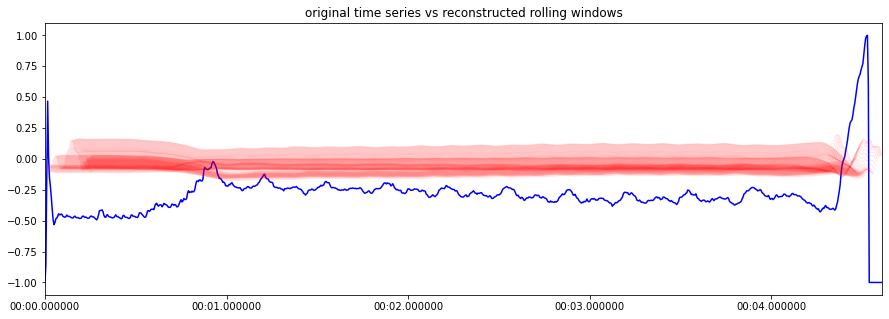

/var/folders/_b/hfgvzy6556bfwk4xnjfgfy0m0000gn/T/ipykernel_25734/1306126569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TimeDateTime'] = pd.to_datetime(df['TimeMS'], unit='ms')


Shape of x from apple frame before reshaping is ()
Shape of x from apple frame after reshaping is (1,)
Shape of x from rolling window is (),n_windows is 918,window size is 50
No Error Here ....


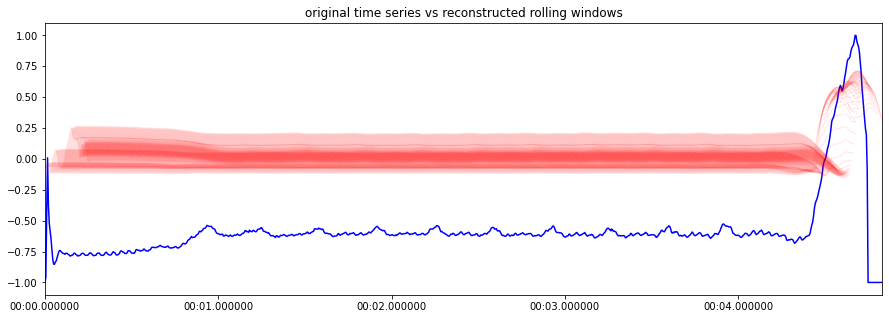

In [70]:
# plot the original time series and reconstructed segments
df=df_merged[df_merged.id==np.random.choice(uniqueids)]
df['TimeDateTime'] = pd.to_datetime(df['TimeMS'], unit='ms')
df = df.set_index(pd.DatetimeIndex(df['TimeDateTime']))
x, t,x_win,t_win=prep_apply_pipeline(df['avg_current'],'5ms',50)
x_win_recon, critic_scores = model.predict(x_win)
plot_time_series(t, x, x_win=x_win_recon,title='original time series vs reconstructed rolling windows')

In [60]:
4

In [65]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = apply_pipeline(x, t, x_win_recon, critic_scores, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

Shape of x from rolling window is (),n_windows is 907,window size is 10
No Error Here ....
Shape of x from rolling window is (),n_windows is 907,window size is 10
No Error Here ....


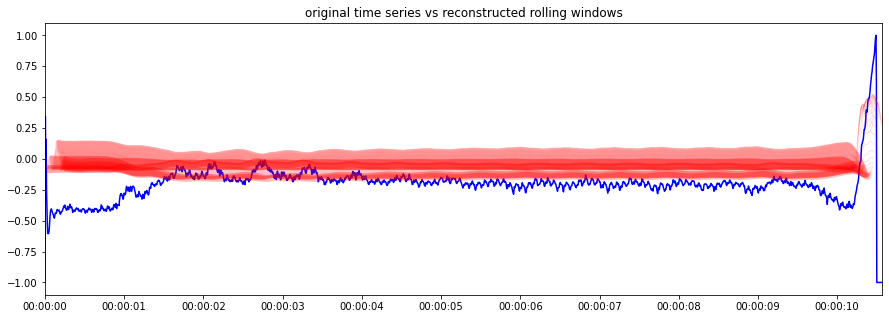

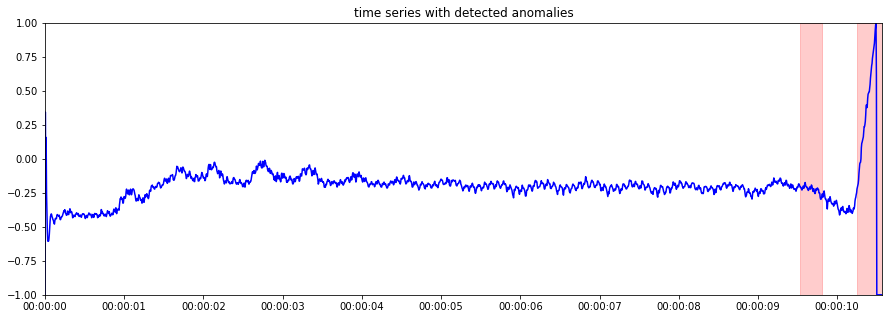

In [93]:
pd.options.mode.chained_assignment = None  # default='warn'
# plot the original time series and reconstructed segments
df=df_merged[df_merged.id==np.random.choice(uniqueids)]
df['TimeDateTime'] = pd.to_datetime(df['TimeMS'], unit='ms')
df = df.set_index(pd.DatetimeIndex(df['TimeDateTime']))
x, t,x_win,t_win=prep_apply_pipeline(df['avg_current'],'5ms',50)
x_win_recon, critic_scores = model.predict(x_win)
plot_time_series(t, x, x_win=x_win_recon,title='original time series vs reconstructed rolling windows')
# plot time series with detected anomalies
detected_intervals, _, _ = apply_pipeline(x, t, x_win_recon, critic_scores, **params)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()
plot_time_series(t, x, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series with detected anomalies')

In [102]:
import dill
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        dill.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        obj=dill.load(outp, pickle.HIGHEST_PROTOCOL)
    return obj

In [107]:
model.encoder_generator_model.save('./encoder_generator')
model.generator.save('./generator')
model.encoder.save('./encoder')

INFO:tensorflow:Assets written to: ./encoder_generator/assets


INFO:tensorflow:Assets written to: ./encoder_generator/assets


INFO:tensorflow:Assets written to: ./generator/assets


INFO:tensorflow:Assets written to: ./generator/assets


INFO:tensorflow:Assets written to: ./encoder/assets


INFO:tensorflow:Assets written to: ./encoder/assets


In [124]:
model.critic_x.save('./critic')

INFO:tensorflow:Assets written to: ./critic/assets


INFO:tensorflow:Assets written to: ./critic/assets


In [123]:
sorted(np.unique(df_merged['id']).tolist())

[2,
 3,
 4,
 5,
 6,
 8,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 29,
 30,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 47,
 49,
 51,
 52,
 53,
 54,
 56,
 57,
 59,
 61,
 62,
 63,
 64,
 66,
 67,
 68,
 70,
 73,
 74,
 75,
 76,
 78,
 79,
 80,
 81,
 84,
 85,
 86,
 87,
 88,
 92,
 96,
 97,
 100,
 102,
 103,
 104,
 105,
 106,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 117,
 118,
 119,
 120,
 121,
 122,
 124,
 125,
 126,
 127,
 130,
 133,
 134,
 135,
 136,
 137,
 139,
 140,
 141,
 146,
 147,
 149,
 151,
 153,
 154,
 155,
 156,
 159,
 160,
 161,
 163,
 164,
 165,
 166,
 167,
 168,
 170,
 171,
 172,
 173,
 174,
 175,
 178,
 179,
 181,
 182,
 184,
 186,
 188,
 189,
 190,
 191,
 193,
 195,
 196,
 197,
 199,
 200,
 202,
 203,
 207,
 208,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 239,
 241,
 243,
 244,
 246,
 247,
 249,
 250,
 251,
 254,
 255,
 256,
 257,
 261,
 262,
 263,
 26

In [126]:
df_merged[df_merged['Reload']=="Black 60"]

,id,TimeMS,Avg_Velocity,PWM_Output,SG_NoFilter,Setpoint,StrainGage,avg_current,current_filter,ticks,True_Endstop_Time_ms,Articulation,Tissue,Tissue_Thickness_inch,Reload,Firing_Type
1181052,265,0,0.00,153,0,33750,0,0,0,0,5711,Full Pull,Stomach,0.09,Black 60,Un-interrupted
1181053,265,1,0.00,165,0,33750,0,0,0,0,5711,Full Pull,Stomach,0.09,Black 60,Un-interrupted
1181054,265,2,0.00,176,0,33750,0,0,0,0,5711,Full Pull,Stomach,0.09,Black 60,Un-interrupted
1181055,265,3,0.00,188,0,33750,0,0,0,0,5711,Full Pull,Stomach,0.09,Black 60,Un-interrupted
1181056,265,4,0.00,199,0,33750,0,0,0,0,5711,Full Pull,Stomach,0.09,Black 60,Un-interrupted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452196,290,21494,187.50,0,88,9375,87,0,0,-40110,21000,Full Push,Stomach,0.12,Black 60,Un-interrupted
1452197,290,21495,125.00,0,88,9375,87,0,0,-40110,21000,Full Push,Stomach,0.12,Black 60,Un-interrupted
1452198,290,21496,93.75,0,88,9375,87,0,0,-40110,21000,Full Push,Stomach,0.12,Black 60,Un-interrupted
1452199,290,21497,62.50,0,88,9375,87,0,0,-40110,21000,Full Push,Stomach,0.12,Black 60,Un-interrupted
